Các thành viên nhóm:
* Nguyễn Đức Anh
* Nguyễn Mạnh Dũng
* Nguyễn Hoàng Nghĩa
* Nguyễn Khánh Toàn
* Chu Cao Nguyên

Giới thiệu dự án: Dự án dưới đây có chủ đề Sentiment Analysis với dữ liệu là phần bình luận (Comments) ở các kênh tiếng Việt trên nền tảng video trực tuyến hàng đầu thế giới là Youtube. 

Mục đích: Cung cấp các kĩ thuật trong việc phân tích và dự đoán cảm xúc của người xem/ người bình luận đối với nội dung video được đăng tải cũng như nội dung trên các kênh.

Lợi ích:
* Người xem: Giúp cho người xem xác định được những kênh/ nội dung được phản hồi ra sao bởi những người xem khác để có thể đưa ra lựa chọn. 
* Người đăng tải: Nhận biết được phản hồi của người xem với nội dung trên kênh để có thể cải thiện hiệu quả, đưa ra giải pháp giúp kênh tối ưu.
* Nền tảng: Xác định được các kênh/ video truyền tải nội dung như thế nào trên quan điểm/ góc nhìn của người xem để có giải pháp can thiệp nếu cần.

Ứng dụng:
* Phát hiện các video truyền tải nội dung xuyên tạc, tiêu cực tới cộng đồng
* Recommendation system: Hướng người xem tới các nội dung được phản hồi tích cực từ người xem khác (user- user collaboration) hoặc gợi ý các video có phản hồi tích cực tương tự các video mà người dùng đã xem (item -item collaboration)

Các thư viện cần dùng

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import string
import requests
import os
import csv
import time
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from googleapiclient.discovery import build
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from word2number import w2n
import emoji
from num2words import num2words
from bs4 import BeautifulSoup
from underthesea import word_tokenize
from underthesea import pos_tag, chunk, ner, text_normalize
from viet_badwords_filter.filter import VNBadwordsFilter

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

Youtube set up API key

Sử dụng Google Console để lấy API Key

In [5]:
# YouTube API setup
# Replace with your API key
api_key = os.getenv('YOUTUBE_API_KEY')
youtube = build('youtube', 'v3', developerKey=api_key)

Extract video

In [6]:
import re
def extract_video_id(url):
    """
    Extract the video ID from a YouTube URL.
    Args:
    url (str): The YouTube video URL.
    Returns:
    str: The video ID or None if invalid URL.
    """
    # Regular expression to match YouTube video IDs
    video_id_match = re.search(r"v=([a-zA-Z0-9_-]{11})", url)
    if video_id_match:
        return video_id_match.group(1)
    else:
        print("Invalid YouTube URL.")
        return None

In [7]:
url = 'https://www.youtube.com/watch?v=5LxjFoypQo4'
video_id = extract_video_id(url)
print("Video ID:", video_id)

Video ID: 5LxjFoypQo4


Extract Comments

In [8]:
def get_comments(video_id):
    comments = []
    request = youtube.commentThreads().list(
        part="snippet",
        videoId=video_id,
        maxResults=100
    )
    response = request.execute()

    while response:
        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            author = item['snippet']['topLevelComment']['snippet']['authorDisplayName']
            comments.append({"Author": author, "Comment": comment})
        
        if 'nextPageToken' in response:
            request = youtube.commentThreads().list(
                part="snippet",
                videoId=video_id,
                pageToken=response['nextPageToken'],
                maxResults=100
            )
            response = request.execute()
        else:
            break
    return comments

Save to file

In [9]:
comments = get_comments(video_id)
df = pd.DataFrame(comments)
df.to_csv("youtube_comments.csv", index=False)
print("Comments saved to youtube_comments.csv")

Comments saved to youtube_comments.csv


**Note**: Dữ liệu hiện tại không có nhãn sẵn, do đây không phải dataset có sẵn

Nhóm có 2 hướng xử lí:
1. Label thủ công: phù hợp với dữ liệu nhỏ, có dư dả thời gian (nhóm đã test)
2. Label bằng lập trình: sử dụng từ điển các từ tốt/ xấu trong tiếng Việt

Data Analysis

In [10]:
data = pd.read_csv("youtube_comments.csv")
data.head()

,Author,Comment
0,@blvanhquan68,Chúc mừng Viettel đã lên ngôi V.League 1 mùa g...
1,@hihieas,Biết là VĂN QUYẾN sai nhưng mà nói đúng cầu th...
2,@NghinhBinh-u4p,Vẫn là đỉnh cao
3,@Fox17vn,xin hoi tai sao ko thi dau nua
4,@truongthan9998,Loại người bán dẻ đất nước


In [11]:
data.shape

(4013, 2)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4013 entries, 0 to 4012
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Author   3998 non-null   object
 1   Comment  4013 non-null   object
dtypes: object(2)
memory usage: 62.8+ KB


Đánh nhãn cho bình luận (Comments)

In [13]:
positive_words = [
        "tuyệt vời", "xuất sắc", "đỉnh", "hay", "vui", "hài hước", "đẹp", "tốt", "thông minh", "chất lượng",
        "hiệu quả", "ấn tượng", "hữu ích", "tử tế", "dễ thương", "thân thiện", "chu đáo", "tinh tế", "mượt mà", "nhanh chóng",
        "chuyên nghiệp", "đáng yêu", "đáng tin", "yên tâm", "đáng giá", "sáng tạo", "nổi bật", "gọn gàng", "sạch sẽ", "ấm cúng",
        "trẻ trung", "tận tình", "hài lòng", "thú vị", "tận tâm", "đáng nể", "hấp dẫn", "ngon", "mạnh mẽ", "sôi nổi",
        "cởi mở", "nhiệt tình", "nhiệt huyết", "sống động", "lịch sự", "vui vẻ", "tôn trọng", "yêu thích", "gần gũi", "tự nhiên",
        "đam mê", "kiên nhẫn", "chuẩn chỉnh", "lôi cuốn", "sâu sắc", "nổi trội", "hòa đồng", "ngăn nắp", "thông thái", "bổ ích",
        "trọn vẹn", "dễ chịu", "hài hòa", "lành mạnh", "nhẹ nhàng", "kỹ lưỡng", "cẩn thận", "đa năng", "thần thái", "thành công",
        "xinh đẹp", "nổi tiếng", "có tâm", "có tầm", "vượt trội", "hoàn hảo", "tinh xảo", "độc đáo", "đa dạng", "linh hoạt",
        "dễ hiểu", "giao tiếp tốt", "thích thú", "thấu hiểu", "bao dung", "sáng sủa", "rõ ràng", "phù hợp", "nhẹ nhàng", "rộng rãi",
        "đậm đà", "thơm ngon", "dồi dào", "an toàn", "trách nhiệm", "kiên cường", "ổn định", "khéo léo", "phấn khởi", "thành thạo"
    ]

more_bad_words_related_to_football = ['xấu', 'cáo già', 'trơ trãn', 'vịt', 'vỡ vẩn']

In [14]:
filter = VNBadwordsFilter()

def label_comments(data, positive_words, bad_words, column='Comment'):
    import pandas as pd

    # Nếu là Series thì chuyển thành DataFrame
    if isinstance(data, pd.Series):
        df = pd.DataFrame({column: data})
    else:
        df = data.copy()

    # Đảm bảo xử lý NaN
    df[column] = df[column].fillna("").astype(str).str.lower()

    def classify(text):
        if any(word in text for word in positive_words):
            return 'Positive'
        elif filter.is_profane(text) or any(word in text for word in bad_words) :  
            return 'Negative'
        else:
            return 'Neutral'

    df['Label'] = df[column].apply(classify)
    return df

In [15]:
data = label_comments(data, positive_words, more_bad_words_related_to_football)
data.head()

,Author,Comment,Label
0,@blvanhquan68,chúc mừng viettel đã lên ngôi v.league 1 mùa g...,Neutral
1,@hihieas,biết là văn quyến sai nhưng mà nói đúng cầu th...,Neutral
2,@NghinhBinh-u4p,vẫn là đỉnh cao,Positive
3,@Fox17vn,xin hoi tai sao ko thi dau nua,Neutral
4,@truongthan9998,loại người bán dẻ đất nước,Neutral


In [16]:
data['Label'].value_counts()

Label
Neutral     3176
Positive     673
Negative     164
Name: count, dtype: int64

In [17]:
# Tách các lớp
neutral_df = data[data['Label'] == 'Neutral']
positive_df = data[data['Label'] == 'Positive']
negative_df = data[data['Label'] == 'Negative']

In [18]:
from sklearn.utils import resample
# Tăng lớp Positive và Negative lên 3175
positive_upsampled = resample(positive_df,
                              replace=True,
                              n_samples=3175,
                              random_state=42)

negative_upsampled = resample(negative_df,
                              replace=True,
                              n_samples=3175,
                              random_state=42)

# Ghép lại
data = pd.concat([neutral_df, positive_upsampled, negative_upsampled])

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9526 entries, 0 to 2300
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Author   9499 non-null   object
 1   Comment  9526 non-null   object
 2   Label    9526 non-null   object
dtypes: object(3)
memory usage: 297.7+ KB


Phương pháp 2: Đánh nhãn random (nhóm không sử dụng)

In [20]:
def assign_labels(df):
    # TODO: Replace with real label logic or pre-labelled dataset
    # Tạm thời tạo label giả random
    df['Label'] = np.random.choice(['Positive', 'Neutral', 'Negative'], len(df))
    return df

In [21]:
data.drop(columns=['Author'], inplace=True)

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9526 entries, 0 to 2300
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  9526 non-null   object
 1   Label    9526 non-null   object
dtypes: object(2)
memory usage: 223.3+ KB


EDA

Kiểm tra dữ liệu bình luận (Comments):
* Lượng từ xuất hiện trong câu
* Các từ/ cụm từ xuất hiện nhiều nhất

In [23]:
lenght = len(data['Comment'][0])
print(f'Length of a sample comment: {lenght}')

Length of a sample comment: 320


In [24]:
word_count = data['Comment'][0].split()
print(f'Word count in a sample comment: {len(word_count)}')

Word count in a sample comment: 42


In [25]:
data1 = data.copy()

Term Frequency Analysis

Examining the most frequently occuring words is one of the most popular systems of Text analytics. For example, in a sentiment analysis problem, a positive text is bound to have words like 'good', 'great', 'nice', etc. more in number than other words that imply otherwise.

Note: Term Frequencies are more than counts and lenghts, so the first requirement is to preprocess the text

In [26]:
data1['mean_word_length'] = data1['Comment'].map(lambda rev: np.mean([len(word) for word in rev.split()]))
data1.head(10)

,Comment,Label,mean_word_length
0,chúc mừng viettel đã lên ngôi v.league 1 mùa g...,Neutral,6.642857
1,biết là văn quyến sai nhưng mà nói đúng cầu th...,Neutral,3.520000
3,xin hoi tai sao ko thi dau nua,Neutral,2.875000
4,loại người bán dẻ đất nước,Neutral,3.500000
5,1 thg chăn bò đi đá bóng quốc gia thì ko bán đ...,Neutral,2.666667
6,"dù đã qua cách đây 20 năm rùi,nhưng lối đá vq ...",Neutral,3.372093
9,có tài mà ko có đức thì cũng vất,Neutral,2.666667
10,trăm năm việt nam mới có 1 thiên tài bóng đá,Neutral,3.090909
11,bóng đá việt nam ko ai có thể qua được cậu bé ...,Neutral,3.266667
12,thời gian trôi nhanh thật đấy đã 5 năm rồi😢😢😢😢,Neutral,3.700000


In [27]:
from nltk import tokenize
np.mean([len(sent) for sent in tokenize.sent_tokenize(data1['Comment'][0])])

159.5

In [28]:
def corpus(text):
    text_list = text.split()
    return text_list

In [29]:
data1['Review_lists'] = data1['Comment'].apply(corpus)
data1.head(10)

,Comment,Label,mean_word_length,Review_lists
0,chúc mừng viettel đã lên ngôi v.league 1 mùa g...,Neutral,6.642857,"[chúc, mừng, viettel, đã, lên, ngôi, v.league,..."
1,biết là văn quyến sai nhưng mà nói đúng cầu th...,Neutral,3.520000,"[biết, là, văn, quyến, sai, nhưng, mà, nói, đú..."
3,xin hoi tai sao ko thi dau nua,Neutral,2.875000,"[xin, hoi, tai, sao, ko, thi, dau, nua]"
4,loại người bán dẻ đất nước,Neutral,3.500000,"[loại, người, bán, dẻ, đất, nước]"
5,1 thg chăn bò đi đá bóng quốc gia thì ko bán đ...,Neutral,2.666667,"[1, thg, chăn, bò, đi, đá, bóng, quốc, gia, th..."
6,"dù đã qua cách đây 20 năm rùi,nhưng lối đá vq ...",Neutral,3.372093,"[dù, đã, qua, cách, đây, 20, năm, rùi,nhưng, l..."
9,có tài mà ko có đức thì cũng vất,Neutral,2.666667,"[có, tài, mà, ko, có, đức, thì, cũng, vất]"
10,trăm năm việt nam mới có 1 thiên tài bóng đá,Neutral,3.090909,"[trăm, năm, việt, nam, mới, có, 1, thiên, tài,..."
11,bóng đá việt nam ko ai có thể qua được cậu bé ...,Neutral,3.266667,"[bóng, đá, việt, nam, ko, ai, có, thể, qua, đư..."
12,thời gian trôi nhanh thật đấy đã 5 năm rồi😢😢😢😢,Neutral,3.700000,"[thời, gian, trôi, nhanh, thật, đấy, đã, 5, nă..."


In [30]:
from tqdm import trange
from nltk.probability import FreqDist
from collections import Counter

In [31]:
corpus = []
for i in trange(data1.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    row = data1['Review_lists'].iloc[i]
    if isinstance(row, list):  # Chỉ cộng nếu là list
        corpus += row
    else:
        print(f"Row {i} is not a list, skipped.")
#for i in trange(data1.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
#   corpus += data1['Review_lists'][i]
#len(corpus)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 9526/9526 [00:00<00:00, 53482.05it/s]


In [32]:
mostCommon = Counter(corpus).most_common(10)
mostCommon

[('có', 4176),
 ('là', 3921),
 ('quyến', 3676),
 ('văn', 2947),
 ('thì', 2873),
 ('đá', 2372),
 ('bán', 2329),
 ('mà', 2234),
 ('bóng', 2230),
 ('cho', 2175)]

In [33]:
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)

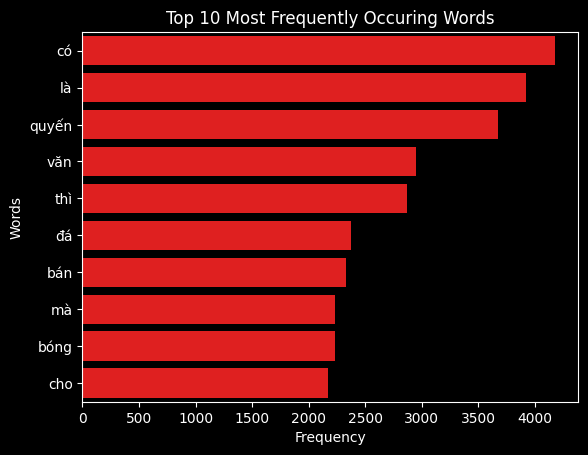

In [34]:
# Thiết lập style nền đen, chữ trắng
plt.style.use('dark_background')

sns.barplot(x=freq, y=words,color='red')
plt.title('Top 10 Most Frequently Occuring Words')
plt.xlabel('Frequency', color='white')  # nhãn trục X chữ trắng (nếu có)
plt.ylabel('Words', color='white')     # nhãn trục Y chữ trắng (nếu có)

# Chỉnh màu chữ cho các ticks (nhãn trục)
plt.xticks(color='white')
plt.yticks(color='white')

plt.show()

Most Frequently occuring N_grams

What is an N-gram?
An n-gram is sequence of n words in a text. Most words by themselves may not present the entire context. Typically adverbs such as 'most' or 'very' are used to modify verbs and adjectives. Therefore, n-grams help analyse phrases and not just words which can lead to better insights.

A Bi-gram means two words in a sequence. 'Very good' or 'Too great'
A Tri-gram means three words in a sequence. 'How was your day' would be broken down to 'How was your' and 'was your day'.

For separating text into n-grams, we will use CountVectorizer from Sklearn

In [35]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df['Comment'])

In [36]:
import numpy as np

# Tính tổng tần suất mà không cần chuyển sang dense matrix
count_values = bigrams.sum(axis=0).A1  # .A1 là rút gọn từ matrix -> ndarray 1D
ngram_freq = pd.DataFrame(
    sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse=True),
    columns=["frequency", "ngram"]
)

In [37]:
#count_values = bigrams.toarray().sum(axis=0)
#ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
#ngram_freq.columns = ["frequency", "ngram"]

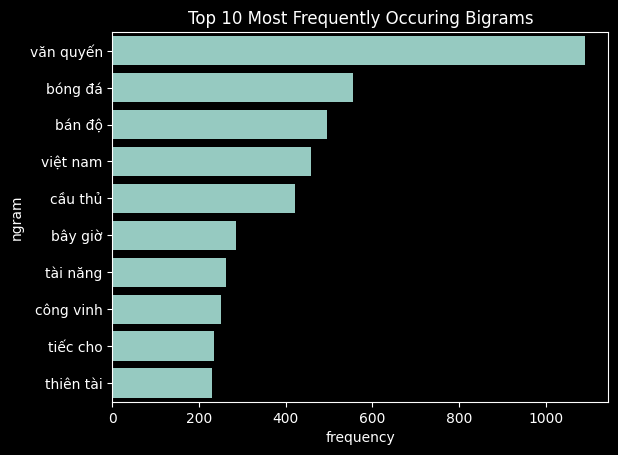

In [38]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

In [39]:
cv1 = CountVectorizer(ngram_range=(3,3))
trigrams = cv1.fit_transform(data1['Comment'])

# Giải pháp tiết kiệm bộ nhớ:
count_values = trigrams.sum(axis=0).A1  # Lấy tổng tần suất theo cột dưới dạng mảng 1 chiều

ngram_freq = pd.DataFrame(
    sorted([(count_values[i], k) for k, i in cv1.vocabulary_.items()], reverse=True),
    columns=["frequency", "ngram"]
)

In [40]:
#cv1 = CountVectorizer(ngram_range=(3,3))
#trigrams = cv1.fit_transform(data1['Comment'])
#count_values = trigrams.toarray().sum(axis=0)
#ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv1.vocabulary_.items()], reverse = True))
#ngram_freq.columns = ["frequency", "ngram"]

Lỗi MemoryError vì đang cố chuyển một ma trận thưa rất lớn (9526 hàng × 63944 cột) thành ma trận đầy đủ với .toarray(), tốn tới 4.54 GB RAM – rất không cần thiết.

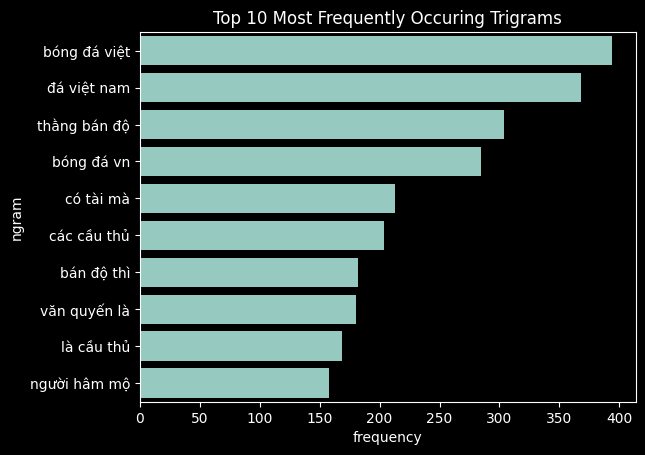

In [41]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Trigrams')
plt.show()

Train- Test Split: Thực hiện trước khi Clean + Processing để tránh Data Leakage

In [42]:
def load_and_split(df, test_size=0.2, random_state=42):   
    # Split into train and test sets
    X = df['Comment'] # Các cột comment
    y = df['Label']  # Cột label
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Create train and test DataFrames
    train = pd.DataFrame({'Comment': X_train, 'Label': y_train})
    test = pd.DataFrame({'Comment': X_test, 'Label': y_test})
    
    return train, test, X_train, y_train, X_test, y_test

# Example usage:
train, test, X_train, y_train, X_test, y_test = load_and_split(data,test_size=0.2, random_state=42)


In [43]:
X_train.shape

(7620,)

In [44]:
y_train.shape

(7620,)

In [45]:
X_test.shape

(1906,)

In [46]:
y_test.shape

(1906,)

In [47]:
train.head()

,Comment,Label
1900,bán nước đúng ngu như chó,Negative
3741,cũng chỉ vì nghèo khó mà ra tiếc cho anh.,Neutral
3016,mãi là niềm nuối tiếc &quot; giá như...&quot;,Neutral
1831,"việt nam ngu như con bò , nó bán độ thì im mẹ ...",Negative
3849,nghệ an đá xấu chỉ có riêng quyến là hào hoa l...,Negative


In [48]:
test.head()

,Comment,Label
73,mày làm nhục cảm người nghệ an tốt bụng,Positive
127,"văn quyến nếu không xa ngã, có thể đã là biểu ...",Positive
579,mình vẫn tiếc cho bạn q ah!,Neutral
2164,"cá nhân, đéo chuyền cho ai. ở tù rồi tiêca",Negative
408,"văn quyến mà gọi là thiên tài,bậy rồi",Neutral


Clean data:
* Xóa các comment chỉ có biểu tượng
* Chuyển hết các số thành từ: ví dụ 2-> hai (do dữ liệu bình luận liên quan đến bóng đá có số: dùng để mỉa mai/khen)
* Chuyển hết các từ về dạng chữ thường
* Xóa dấu câu và stop words: không mang nhiều giá trị
* Xóa link đính kèm (nhiều người gán link Shopee để lừa người khác) hay thẻ HTML (do quá trình lấy dữ liệu)

In [49]:
vietnamese_stopwords = [
    'và', 'là', 'của', 'có', 'trong', 'một', 'những', 'được', 'với', 'cho', 'khi', 
    'này', 'ở', 'đã', 'các', 'đó', 'theo', 'ra', 'từ', 'vì', 'nên', 'sẽ', 'đang', 
    'như', 'đến', 'thì', 'bị', 'rằng', 'mà', 'làm', 'hay', 'nào', 'ta', 'tôi', 'anh', 'chị', 
    'em', 'chúng', 'tôi', 'bạn', 'họ', 'gì', 'đâu', 'ai', 'đấy'
    # 👉 bạn có thể mở rộng thêm nếu cần
]

In [50]:
def clean_single_text(text):
    # Kiểm tra nếu text không phải chuỗi hoặc là NaN
    if not isinstance(text, str):
        return ''

    # Nếu không chứa ít nhất 1 ký tự chữ hoặc số => loại bỏ
    if not re.search(r'[a-zA-Z0-9À-ỹà-ỹ]', text):  # hỗ trợ cả chữ tiếng Việt
        return ''

    text = text.strip()

    # ===== ƯU TIÊN xử lý nếu comment BẮT ĐẦU bằng số hoặc emoji =====
    if re.match(r'^\d+', text):  # bắt đầu bằng số
        # chuyển số đầu tiên sang chữ
        text = re.sub(r'^\d+', lambda x: num2words(int(x.group()), lang='vi'), text)

    elif emoji.is_emoji(text[0]):
        # Xoá emoji ở đầu nếu có
        text = emoji.replace_emoji(text, replace='') #only_first=True)

    # ================== CÁC BƯỚC LÀM SẠCH CHUNG ==================

    # Chuyển tất cả thành chữ thường
    text = text.lower()

    # Loại bỏ HTML/CSS
    text = BeautifulSoup(text, "html.parser").get_text()

    # Xóa URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Loại bỏ emoji còn lại
    text = emoji.replace_emoji(text, replace='')

    # Chuyển tất cả số còn lại sang chữ 
    # 2 thằng cầu thủ -> hai ...
    text = re.sub(r'\d+', lambda x: num2words(int(x.group()), lang='vi'), text)

    # Xoá dấu câu
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tách từ và loại bỏ stopwords
    # là, như,...
    tokens = word_tokenize(text)
    filtered_words = [w for w in tokens if w not in vietnamese_stopwords]

    # Nếu sau khi xử lý mà còn rỗng thì bỏ
    if not filtered_words:
        return ''

    return ' '.join(filtered_words)

def clean_text(data, column=None):
    if isinstance(data, pd.Series):
        return data.apply(clean_single_text)
    elif isinstance(data, pd.DataFrame):
        if column is None:
            raise ValueError("Cần chỉ định tên cột để xử lý trong DataFrame.")
        return data[column].apply(clean_single_text)
    else:
        raise TypeError("Input phải là pandas Series hoặc DataFrame.")

In [51]:
cleaned_X_train = clean_text(X_train)

C:\Users\admin\AppData\Local\Temp\ipykernel_4068\1424402601.py:27: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()
C:\Users\admin\AppData\Local\Temp\ipykernel_4068\1424402601.py:27: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


In [52]:
cleaned_X_train.shape

(7620,)

In [53]:
y_train.shape

(7620,)

In [54]:
nan_indices = cleaned_X_train[cleaned_X_train.isnull()].index
y_train.drop(nan_indices, inplace = True)

In [55]:
y_train.shape

(7620,)

In [56]:
cleaned_X_train.shape

(7620,)

In [ ]:
cleaned_X_train.dropna(inplace = True)

In [57]:
cleaned_x_test = clean_text(X_test)

C:\Users\admin\AppData\Local\Temp\ipykernel_4068\1424402601.py:27: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


In [58]:
cleaned_x_test.isna().sum()

0

In [59]:
cleaned_X_train.isna().sum()

0

In [60]:
y_test.isna().sum()

0

In [61]:
y_train.isna().sum()

0

Tokenization & Lemmatization

In [62]:
def tokenize_and_lemmatize_single(text):
    if not isinstance(text, str):
        return None
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized)

def tokenize_and_lemmatize(data, column=None, new_column=None):
    if isinstance(data, pd.Series):
        return data.apply(tokenize_and_lemmatize_single)
    elif isinstance(data, pd.DataFrame):
        if column is None:
            raise ValueError("Cần chỉ định tên cột văn bản để xử lý.")
        result = data[column].apply(tokenize_and_lemmatize_single)
        if new_column:
            data[new_column] = result
            return data
        else:
            return result
    else:
        raise TypeError("Input phải là pandas Series hoặc DataFrame.")

In [63]:
token_X_train = tokenize_and_lemmatize(cleaned_X_train)
token_X_test = tokenize_and_lemmatize(cleaned_x_test)

In [64]:
token_X_train.shape

(7620,)

In [66]:
y_train.shape

(7620,)

In [67]:
token_X_test.shape

(1906,)

In [68]:
y_test.shape

(1906,)

Vectorization

In [69]:
def vectorize_text(train_df, test_df, method='tfidf'):
    """
    Vectorizes all text columns in train and test DataFrames by concatenating all column values per row.

    Parameters:
        train_df (DataFrame): Training DataFrame with all text columns.
        test_df (DataFrame): Testing DataFrame with all text columns.
        method (str): 'tfidf' (default) or 'bow'

    Returns:
        X_train (sparse matrix), X_test (sparse matrix), vectorizer (fitted vectorizer)
    """

    # Initialize vectorizer
    vectorizer = CountVectorizer() if method == 'bow' else TfidfVectorizer()

    # Fit on train and transform both
    X_train = vectorizer.fit_transform(train_df)
    X_test = vectorizer.transform(test_df)

    return X_train, X_test, vectorizer

In [70]:
vectorized_X_train, vectorize_X_test, vectorizer = vectorize_text(token_X_train, token_X_test)

In [71]:
vectorized_X_train.shape

(7620, 4269)

In [72]:
y_train.shape

(7620,)

Machine Learning model

In [73]:
def train_and_evaluate_models(X_train, y_train, X_test, y_test):
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000),
        "Naive Bayes": MultinomialNB(),
        "SVM": SVC(),
        "KNN": KNeighborsClassifier(),
        "Decision Tree": DecisionTreeClassifier(),
        "Random Forest": RandomForestClassifier()
        # "Maximum Entropy" trùng với Logistic Regression
    }

    results = {}

    for name, model in models.items():
        print(f"\n=== Training {name} ===")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Lưu kết quả
        results[name] = {
            'model': model,
            'y_pred': y_pred,
            'accuracy': accuracy_score(y_test, y_pred),
            'report': classification_report(y_test, y_pred, output_dict=True),
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        }

        # In kết quả
        print(f"Accuracy: {results[name]['accuracy']:.4f}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

    return results

In [74]:
result = train_and_evaluate_models(vectorized_X_train, y_train, vectorize_X_test, y_test)


=== Training Logistic Regression ===
Accuracy: 0.9339
Classification Report:
              precision    recall  f1-score   support

    Negative       0.98      1.00      0.99       639
     Neutral       0.95      0.86      0.90       653
    Positive       0.88      0.94      0.91       614

    accuracy                           0.93      1906
   macro avg       0.93      0.93      0.93      1906
weighted avg       0.94      0.93      0.93      1906

Confusion Matrix:
[[639   0   0]
 [ 11 563  79]
 [  5  31 578]]

=== Training Naive Bayes ===
Accuracy: 0.7970
Classification Report:
              precision    recall  f1-score   support

    Negative       0.84      0.98      0.90       639
     Neutral       0.95      0.50      0.66       653
    Positive       0.69      0.92      0.79       614

    accuracy                           0.80      1906
   macro avg       0.83      0.80      0.78      1906
weighted avg       0.83      0.80      0.78      1906

Confusion Matrix:
[[628   

Bảng so sánh các kết quả

In [75]:
def plot_model_comparison_table(results_dict):
    """
    Tạo bảng so sánh các metric (Accuracy, Precision, Recall, F1-score) giữa các mô hình.
    
    Parameters:
        results_dict: dict - Kết quả trả về từ hàm train_and_evaluate_models()
    """
    rows = []
    for model_name, res in results_dict.items():
        report = res['report']
        accuracy = res['accuracy']
        precision = report['weighted avg']['precision']
        recall = report['weighted avg']['recall']
        f1 = report['weighted avg']['f1-score']

        rows.append({
            'Model': model_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-score': f1
        })

    df = pd.DataFrame(rows)
    df = df.sort_values(by="F1-score", ascending=False)

    print("\n=== Bảng so sánh hiệu suất các mô hình ===")
    print(df.to_string(index=False))

    # Vẽ biểu đồ cột nếu muốn
    df.plot(x='Model', y=['Accuracy', 'Precision', 'Recall', 'F1-score'], kind='bar', figsize=(12,6))
    plt.title('So sánh các mô hình ML')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()



=== Bảng so sánh hiệu suất các mô hình ===
              Model  Accuracy  Precision   Recall  F1-score
                SVM  0.980063   0.980187 0.980063  0.980067
      Random Forest  0.977964   0.978642 0.977964  0.977954
Logistic Regression  0.933893   0.935195 0.933893  0.933464
      Decision Tree  0.932319   0.940965 0.932319  0.931454
        Naive Bayes  0.796957   0.830647 0.796957  0.782908
                KNN  0.762329   0.834914 0.762329  0.735982


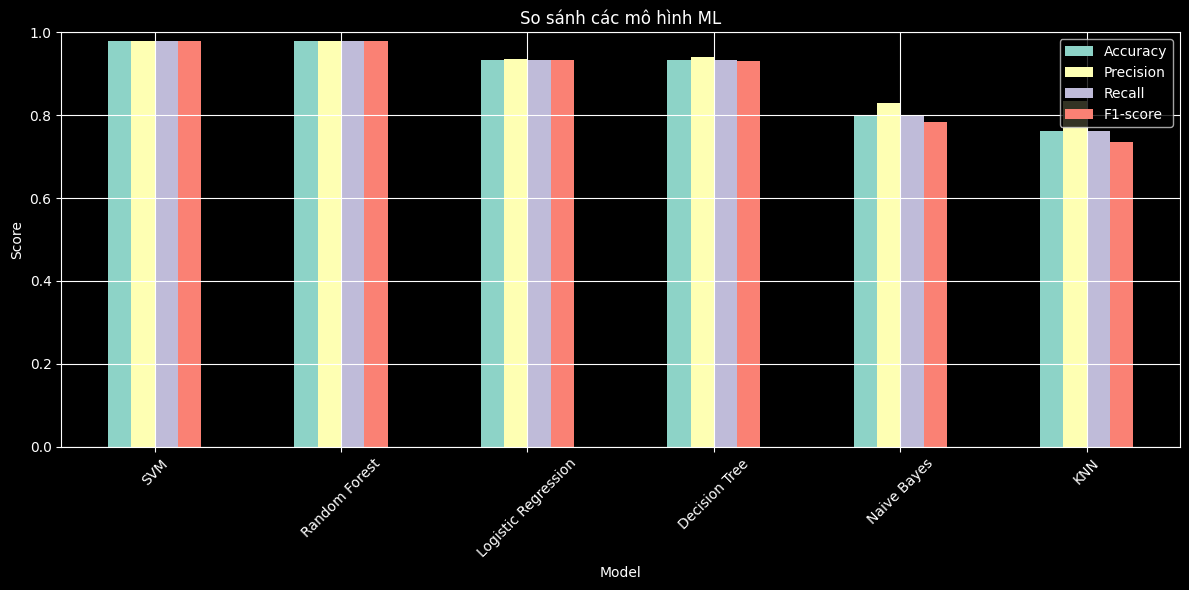

In [76]:
plot_model_comparison_table(result)

Ban đầu khi thử nghiệm trên tập dữ liệu nhỏ các mô hình có kết quả tương đối tệ, đặc biệt là SVM. Tuy nhiên khi dữ liệu thực tế lớn thì gió đổi chiều và SVM trở nên hiệu quả hơn. Thứ tự các mô hình không thay đổi. 

SVM và Random Forest là những mô hình phù hợp cho bài toán với khả năng tổng quát hóa tốt.
Logistic Regression và Decision Tree là những mô hình đơn giản, triển khai với tốc độ nhanh và phù hợp với dữ liệu tuyến tính như dạng vector của text.\

KNN không phù hợp

Sentiment Analysis by NLTK

In [102]:
# Ensure that the VADER lexicon is downloaded
nltk.download('vader_lexicon')

# Initialize the sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [103]:
# Function to analyze sentiment of the comments
def analyze_sentiment(text):
    sentiment_score = sia.polarity_scores(text)
    compound_score = sentiment_score['compound']
    
    if compound_score >= 0.05:
        sentiment = 'Positive'
    elif compound_score <= -0.05:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'
    
    return sentiment, compound_score

In [104]:
def get_comments_1(video_id):
    comments = []
    
    # Make an API request to fetch comments
    request = youtube.commentThreads().list(
        part='snippet',
        videoId=video_id,
        textFormat='plainText'
    )
    
    while request:
        response = request.execute()

        # Loop through the comment threads and extract the comment text
        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            comments.append(comment)

        # Get the next page of comments (if any)
        request = youtube.commentThreads().list_next(request, response)
    
    return comments

In [105]:
# Function to scrape comments, perform sentiment analysis, and write results to CSV
def scrape_and_analyze():
    # Get comments from the YouTube video
    comments = get_comments_1(video_id)

    # Write comments to a text file
    with open('comments.txt', 'w', encoding='utf-8') as file:
        for index, comment in enumerate(comments, 1):
            file.write(f"{index}. {comment}\n")

    # Perform sentiment analysis on all the comments
    all_comments = ' '.join(comment.strip() for comment in comments)
    overall_sentiment, sentiment_score = analyze_sentiment(all_comments)

    # Get current timestamp
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    # Define the CSV file and column names
    csv_file = 'comments_analysis.csv'
    fieldnames = ['Timestamp', 'Comment Count', 'Sentiment Type', 'Sentiment Score', 'Video Type']

    # Open the CSV file to write data
    with open(csv_file, 'a', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        # If the file is empty, write the header (column names)
        if csvfile.tell() == 0:
            writer.writeheader()

        # Write the timestamp, total comments fetched, sentiment type, and score
        writer.writerow({
            'Timestamp': timestamp, 
            'Comment Count': len(comments),
            'Sentiment Type': overall_sentiment, 
            'Sentiment Score': sentiment_score,
            'Video Type': overall_sentiment
        })

    # Output the result
    print(f"Time: {timestamp} | Sentiment: {overall_sentiment} | Sentiment score: {sentiment_score}")

    return timestamp, len(comments), overall_sentiment

In [ ]:
# Run the scraper once and then repeat it every 15 minutes
while True:
    timestamp, comment_count, sentiment = scrape_and_analyze()  # Perform scraping and analysis
    #time.sleep(900)  # Sleep for 15 minutes (900 seconds)

Time: 2025-05-06 00:29:24 | Sentiment: Negative | Sentiment score: -0.9998
Time: 2025-05-06 00:29:56 | Sentiment: Negative | Sentiment score: -0.9998


LLM

In [79]:
import google.generativeai as genai

In [80]:
from tqdm import tqdm

In [81]:
genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))
generation_config = genai.types.GenerationConfig(temperature=0.0)

In [ ]:
# Load mô hình: mô hình free
model = genai.GenerativeModel(model_name="gemini-1.5-flash")

In [83]:
# Hàm phân tích sentiment
def analyze_sentiment(text):
    if pd.isna(text) or not text.strip():
        return "neutral"  # hoặc return None nếu muốn bỏ qua
    prompt = f"""
    Your role: Sentiment analyzer
    Task: Answer the one of sentiment in the sentiment list (["Neutral", "Negative", "Positive"]) of the given message. Only give me the answer in list.
    Message: {text}
    """
    try:
        response = model.generate_content(prompt, generation_config=generation_config)
        return response.text.strip().lower()
    except Exception as e:
        print(f"Lỗi với message: {text[:30]}... => {e}")
        return "neutral"  # fallback nếu lỗi

In [85]:
def evaluate_llm_predictions(y_true, y_pred):
    """
    Evaluate the predictions made by LLM (e.g., Gemini) for sentiment classification.

    Args:
        y_true (list or Series): Ground truth sentiment labels.
        y_pred (list): Predicted sentiment labels from LLM.

    Prints:
        Accuracy, classification report, confusion matrix.
        
    Returns:
        metrics_df (DataFrame): Summary of precision, recall, f1-score per label.
    """
    print("=== Accuracy ===")
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc:.4f}")

    print("\n=== Classification Report ===")
    report = classification_report(y_true, y_pred, output_dict=True)
    print(classification_report(y_true, y_pred))

    print("=== Confusion Matrix ===")
    cm = confusion_matrix(y_true, y_pred, labels=["positive", "neutral", "negative"])
    cm_df = pd.DataFrame(cm, index=["True_Pos", "True_Neu", "True_Neg"], 
                              columns=["Pred_Pos", "Pred_Neu", "Pred_Neg"])
    print(cm_df)

    metrics_df = pd.DataFrame(report).transpose()
    return metrics_df

In [90]:
# Đánh giá
metrics_df = evaluate_llm_predictions(y_test, test['Label'])

=== Accuracy ===
Accuracy: 0.0000

=== Classification Report ===
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00     639.0
     Neutral       0.00      0.00      0.00     653.0
    Positive       0.00      0.00      0.00     614.0
["negative"]       0.00      0.00      0.00       0.0
 ["neutral"]       0.00      0.00      0.00       0.0
["positive"]       0.00      0.00      0.00       0.0

    accuracy                           0.00    1906.0
   macro avg       0.00      0.00      0.00    1906.0
weighted avg       0.00      0.00      0.00    1906.0

=== Confusion Matrix ===


c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

ValueError: At least one label specified must be in y_true

In [87]:
# Áp dụng lên toàn bộ DataFrame
tqdm.pandas()
test["Label"] = test["Comment"].progress_apply(analyze_sentiment)

100%|██████████| 1906/1906 [14:54<00:00,  2.13it/s] 


In [88]:
print(test["Label"])

73      ["negative"]
127     ["negative"]
579     ["negative"]
2164    ["negative"]
408     ["negative"]
            ...     
3773     ["neutral"]
2264    ["negative"]
3689    ["negative"]
3414    ["negative"]
899     ["negative"]
Name: Label, Length: 1906, dtype: object


**Tổng kết**:
* Các mô hình học máy Machine Learning sử dụng tốt trong các bài toán Sentiment Analysis.
* Trừ trường hợp ngữ cảnh (context) quá phức tạp, các mô hình ngôn ngữ lớn (LLM) mới vượt trội hơn so với Machine Learning. Dữ liệu nhỏ không phải vấn đề
* Lexicon- based: phù hợp với dữ liệu text có khuôn mẫu sẵn có hơn dạng free- style (do nó là ruled-based)